In [ ]:
# Cambiar el nombre del proyecto xbox-joystick al usado por su cuenta de Roboflow

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0T6RFylOHeX4QjCixrSE")
project = rf.workspace("elijoel").project("lata-tqoqd")
version = project.version(1)
dataset = version.download("yolov11")

In [ ]:
# model = YOLO('yolo11s.pt')

In [ ]:
# data_path = 'yolo-6/data.yaml'
# results = model.train(
#     data=data_path,
#     epochs=10,
#     imgsz=640,
#     batch=16,          # Reducir batch
#     patience=50,       # Más paciencia
#     cache='disk',      # Menos varianza
#     plots=True,
#     lr0=0.0005,        # 20x más bajo
#     lrf=0.00005,       # Final LR muy bajo
#     warmup_epochs=10,  # Calentar más lento
#     warmup_bias_lr=0.05,
#     hsv_h=0.02,
#     hsv_s=0.7,
#     hsv_v=0.4,
#     degrees=10.0,      # Más rotación
#     translate=0.2,     # Más traslación
#     scale=0.6,         # Más escala
#     fliplr=0.5,
#     mixup=0.1,         # Agregar mixup
#     mosaic=1.0,
#     dropout=0.1,       # Agregar dropout
#     weight_decay=0.001,
#     optimizer='SGD',
#     momentum=0.9
# )

In [ ]:
# custom_model = YOLO('./runs/detect/train/weights/best.pt')

In [ ]:
# res = custom_model('yolo-6/test/images/')

In [ ]:
# res[100].show()

In [ ]:
# import shutil
# from google.colab import files
# import os

# # --- Configuración ---
# carpeta_origen = 'runs/'  # Ruta de la carpeta que quieres comprimir
# zip_destino = '/content/imagenes_comprimidas.zip'  # Nombre del archivo zip de salida

# # --- Comprimir la carpeta ---
# shutil.make_archive(base_name=zip_destino.replace('.zip',''), format='zip', root_dir=carpeta_origen)

# # --- Descargar el archivo ---
# files.download(zip_destino)


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0T6RFylOHeX4QjCixrSE")
project = rf.workspace("elijoel").project("lata-tqoqd")
version = project.version(1)
dataset = version.download("yolov11")

In [2]:
import yaml
import os

# 1. Identify the root directory of the dataset
dataset_root = dataset.location
print(f"Dataset root directory: {dataset_root}")

# 2. Read the data.yaml file
data_yaml_path = os.path.join(dataset_root, 'data.yaml')

with open(data_yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)

# Extract information
class_names = data_yaml['names']

# Get relative paths for train, val, test images and labels
train_img_dir = os.path.join(dataset_root, data_yaml['train'])
val_img_dir = os.path.join(dataset_root, data_yaml['val'])
test_img_dir = os.path.join(dataset_root, data_yaml['test'])

# Assuming labels are in 'labels' directory parallel to 'images' for each split
train_label_dir = os.path.join(os.path.dirname(train_img_dir), 'labels')
val_label_dir = os.path.join(os.path.dirname(val_img_dir), 'labels')
test_label_dir = os.path.join(os.path.dirname(test_img_dir), 'labels')

print(f"Class names: {class_names}")
print(f"Train images directory: {train_img_dir}")
print(f"Train labels directory: {train_label_dir}")
print(f"Validation images directory: {val_img_dir}")
print(f"Validation labels directory: {val_label_dir}")
print(f"Test images directory: {test_img_dir}")
print(f"Test labels directory: {test_label_dir}")

# Store the class names for later use
class_mapping = {i: name for i, name in enumerate(class_names)}
print(f"Class ID to Name Mapping: {class_mapping}")

Dataset root directory: /content/LATA-1
Class names: ['danada', 'defectuosa', 'sana']
Train images directory: /content/LATA-1/../train/images
Train labels directory: /content/LATA-1/../train/labels
Validation images directory: /content/LATA-1/../valid/images
Validation labels directory: /content/LATA-1/../valid/labels
Test images directory: /content/LATA-1/../test/images
Test labels directory: /content/LATA-1/../test/labels
Class ID to Name Mapping: {0: 'danada', 1: 'defectuosa', 2: 'sana'}


In [3]:
from collections import Counter

def parse_yolo_labels(image_dir, label_dir, class_mapping):
    image_paths = []
    class_labels = []
    img_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff'] # Common image extensions

    # Ensure label directory exists
    if not os.path.exists(label_dir):
        print(f"Warning: Label directory not found: {label_dir}")
        return image_paths, class_labels

    for label_file_name in os.listdir(label_dir):
        if label_file_name.endswith('.txt'):
            label_file_path = os.path.join(label_dir, label_file_name)
            image_name_base = os.path.splitext(label_file_name)[0]

            # Attempt to find the corresponding image file with common extensions
            image_path = None
            for ext in img_extensions:
                potential_image_path = os.path.join(image_dir, image_name_base + ext)
                if os.path.exists(potential_image_path):
                    image_path = potential_image_path
                    break

            if image_path is None:
                # If image not found, try common image directory names (e.g., 'images' within image_dir)
                # This handles cases where image_dir might be one level up from the actual image files
                # For instance, if image_dir is '/content/LATA-1/../train/images' and image files are directly in there.
                # The os.path.join(os.path.dirname(image_dir), 'images', image_name_base + ext) logic is implicit in image_dir itself.
                # The robust way is to check the *actual* image_dir content for matching file names.
                # Given the previous step's output '/content/LATA-1/../train/images', actual path is '/train/images'
                # Let's adjust image_dir to be absolute and correct relative parts from data.yaml output.
                abs_image_dir = os.path.abspath(image_dir)

                # Re-check for images in the resolved absolute path
                for ext in img_extensions:
                    potential_image_path = os.path.join(abs_image_dir, image_name_base + ext)
                    if os.path.exists(potential_image_path):
                        image_path = potential_image_path
                        break

            if image_path is None:
                print(f"Warning: Image not found for label file: {label_file_path}")
                continue

            class_ids = []
            with open(label_file_path, 'r') as f:
                for line in f:
                    try:
                        class_id = int(line.strip().split(' ')[0])
                        class_ids.append(class_id)
                    except (ValueError, IndexError):
                        # Handle empty lines or malformed lines in label file
                        continue

            if class_ids:
                # Determine the most frequent class ID
                most_common_class_id = Counter(class_ids).most_common(1)[0][0]
                image_paths.append(image_path)
                class_labels.append(class_mapping[most_common_class_id])
            else:
                # Strategy for images with no annotations: skip for now or assign a 'no_object' class
                # For this task, we'll skip if no objects are detected as it's for classification of objects.
                print(f"Warning: No annotations found in {label_file_path}. Skipping image.")

    return image_paths, class_labels

# Correct the relative paths from the data.yaml output
# The paths from data.yaml like '../train/images' are relative to data.yaml,
# but when os.path.join(dataset_root, ...) is used, it might lead to incorrect absolute paths.
# Let's resolve them properly.

# Helper to get corrected absolute paths from dataset_root and data_yaml entries
def get_absolute_path(base_dir, relative_path_from_yaml):
    # The relative_path_from_yaml is relative to the *data.yaml* file's directory,
    # which is dataset_root in this case.
    # So, we join dataset_root with the relative path.
    return os.path.abspath(os.path.join(base_dir, relative_path_from_yaml))

train_img_dir_abs = get_absolute_path(dataset_root, data_yaml['train'])
train_label_dir_abs = get_absolute_path(dataset_root, data_yaml['train'].replace('images', 'labels'))

val_img_dir_abs = get_absolute_path(dataset_root, data_yaml['val'])
val_label_dir_abs = get_absolute_path(dataset_root, data_yaml['val'].replace('images', 'labels'))

test_img_dir_abs = get_absolute_path(dataset_root, data_yaml['test'])
test_label_dir_abs = get_absolute_path(dataset_root, data_yaml['test'].replace('images', 'labels'))

print(f"Corrected Train images directory: {train_img_dir_abs}")
print(f"Corrected Train labels directory: {train_label_dir_abs}")
print(f"Corrected Val images directory: {val_img_dir_abs}")
print(f"Corrected Val labels directory: {val_label_dir_abs}")
print(f"Corrected Test images directory: {test_img_dir_abs}")
print(f"Corrected Test labels directory: {test_label_dir_abs}")

# Process each split
train_image_paths, train_class_labels = parse_yolo_labels(train_img_dir_abs, train_label_dir_abs, class_mapping)
val_image_paths, val_class_labels = parse_yolo_labels(val_img_dir_abs, val_label_dir_abs, class_mapping)
test_image_paths, test_class_labels = parse_yolo_labels(test_img_dir_abs, test_label_dir_abs, class_mapping)

print(f"\nTrain set: {len(train_image_paths)} images processed")
print(f"Validation set: {len(val_image_paths)} images processed")
print(f"Test set: {len(test_image_paths)} images processed")

# Display a few examples from the training set
print("\nTrain set examples:")
for i in range(min(5, len(train_image_paths))):
    print(f"Image: {train_image_paths[i]}, Label: {train_class_labels[i]}")


Corrected Train images directory: /content/train/images
Corrected Train labels directory: /content/train/labels
Corrected Val images directory: /content/valid/images
Corrected Val labels directory: /content/valid/labels
Corrected Test images directory: /content/test/images
Corrected Test labels directory: /content/test/labels

Train set: 0 images processed
Validation set: 0 images processed
Test set: 0 images processed

Train set examples:


In [4]:
from collections import Counter

def parse_yolo_labels(image_dir, label_dir, class_mapping):
    image_paths = []
    class_labels = []
    img_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff'] # Common image extensions

    # Ensure label directory exists
    if not os.path.exists(label_dir):
        print(f"Warning: Label directory not found: {label_dir}")
        return image_paths, class_labels

    for label_file_name in os.listdir(label_dir):
        if label_file_name.endswith('.txt'):
            label_file_path = os.path.join(label_dir, label_file_name)
            image_name_base = os.path.splitext(label_file_name)[0]

            image_path = None
            for ext in img_extensions:
                potential_image_path = os.path.join(image_dir, image_name_base + ext)
                if os.path.exists(potential_image_path):
                    image_path = potential_image_path
                    break

            if image_path is None:
                print(f"Warning: Image not found for label file: {label_file_path}")
                continue

            class_ids = []
            with open(label_file_path, 'r') as f:
                for line in f:
                    try:
                        class_id = int(line.strip().split(' ')[0])
                        class_ids.append(class_id)
                    except (ValueError, IndexError):
                        # Handle empty lines or malformed lines in label file
                        continue

            if class_ids:
                # Determine the most frequent class ID
                most_common_class_id = Counter(class_ids).most_common(1)[0][0]
                image_paths.append(image_path)
                class_labels.append(class_mapping[most_common_class_id])
            else:
                # Strategy for images with no annotations: skip for now or assign a 'no_object' class
                # For this task, we'll skip if no objects are detected as it's for classification of objects.
                print(f"Warning: No annotations found in {label_file_path}. Skipping image.")

    return image_paths, class_labels

# Correct the relative paths from the data.yaml output
# The paths from data.yaml like '../train/images' are relative to data.yaml,
# but Roboflow's `download` function typically places the train/valid/test folders *inside* the dataset_root.

train_img_dir_abs = os.path.join(dataset_root, 'train', 'images')
train_label_dir_abs = os.path.join(dataset_root, 'train', 'labels')

val_img_dir_abs = os.path.join(dataset_root, 'valid', 'images')
val_label_dir_abs = os.path.join(dataset_root, 'valid', 'labels')

test_img_dir_abs = os.path.join(dataset_root, 'test', 'images')
test_label_dir_abs = os.path.join(dataset_root, 'test', 'labels')

print(f"Corrected Train images directory: {train_img_dir_abs}")
print(f"Corrected Train labels directory: {train_label_dir_abs}")
print(f"Corrected Val images directory: {val_img_dir_abs}")
print(f"Corrected Val labels directory: {val_label_dir_abs}")
print(f"Corrected Test images directory: {test_img_dir_abs}")
print(f"Corrected Test labels directory: {test_label_dir_abs}")

# Process each split
train_image_paths, train_class_labels = parse_yolo_labels(train_img_dir_abs, train_label_dir_abs, class_mapping)
val_image_paths, val_class_labels = parse_yolo_labels(val_img_dir_abs, val_label_dir_abs, class_mapping)
test_image_paths, test_class_labels = parse_yolo_labels(test_img_dir_abs, test_label_dir_abs, class_mapping)

print(f"\nTrain set: {len(train_image_paths)} images processed")
print(f"Validation set: {len(val_image_paths)} images processed")
print(f"Test set: {len(test_image_paths)} images processed")

# Display a few examples from the training set
print("\nTrain set examples:")
for i in range(min(5, len(train_image_paths))):
    print(f"Image: {train_image_paths[i]}, Label: {train_class_labels[i]}")


Corrected Train images directory: /content/LATA-1/train/images
Corrected Train labels directory: /content/LATA-1/train/labels
Corrected Val images directory: /content/LATA-1/valid/images
Corrected Val labels directory: /content/LATA-1/valid/labels
Corrected Test images directory: /content/LATA-1/test/images
Corrected Test labels directory: /content/LATA-1/test/labels

Train set: 725 images processed
Validation set: 207 images processed
Test set: 103 images processed

Train set examples:
Image: /content/LATA-1/train/images/Imagen-de-WhatsApp-2025-11-21-a-las-14_54_16_3919aec9_flip_rotate_1_jpg.rf.5ec692d4e68f113e7d09b49de3ce6362.jpg, Label: defectuosa
Image: /content/LATA-1/train/images/Imagen-de-WhatsApp-2025-11-21-a-las-14_53_23_a92675b9_width_height_shift_2_jpg.rf.b5734fac905c9e670b2ba0418ff0db89.jpg, Label: sana
Image: /content/LATA-1/train/images/IMG-20251121-WA0092_pixelation_2_jpg.rf.c82177b0940f9abc337b02ac234d8284.jpg, Label: danada
Image: /content/LATA-1/train/images/Imagen-de

In [5]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# 1. Define the CustomImageDataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, class_labels, class_to_idx_mapping, transform=None):
        self.image_paths = image_paths
        self.class_labels = class_labels
        self.class_to_idx_mapping = class_to_idx_mapping
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label_str = self.class_labels[idx]
        label_id = self.class_to_idx_mapping[label_str]

        if self.transform:
            image = self.transform(image)

        return image, label_id

# 2. Define image transformations
# ImageNet mean and std for normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transformations with data augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), # ResNet input size is typically 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Validation and Test transformations (no augmentation, only resizing and normalization)
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# 3. Create a mapping from class names (strings) to numeric IDs
# The 'class_names' variable was defined in a previous cell: ['danada', 'defectuosa', 'sana']
# The 'class_mapping' variable was defined as {i: name}, we need {name: i}
name_to_id_mapping = {name: i for i, name in enumerate(class_names)}
print(f"Class Name to ID Mapping: {name_to_id_mapping}")

# 4. Instantiate CustomImageDataset objects for each split
train_dataset = CustomImageDataset(
    image_paths=train_image_paths,
    class_labels=train_class_labels,
    class_to_idx_mapping=name_to_id_mapping,
    transform=train_transforms
)

val_dataset = CustomImageDataset(
    image_paths=val_image_paths,
    class_labels=val_class_labels,
    class_to_idx_mapping=name_to_id_mapping,
    transform=val_test_transforms
)

test_dataset = CustomImageDataset(
    image_paths=test_image_paths,
    class_labels=test_class_labels,
    class_to_idx_mapping=name_to_id_mapping,
    transform=val_test_transforms
)

print(f"\nTrain Dataset size: {len(train_dataset)} samples")
print(f"Validation Dataset size: {len(val_dataset)} samples")
print(f"Test Dataset size: {len(test_dataset)} samples")

# 5. Create DataLoader objects for each dataset
batch_size = 32 # Common batch size
num_workers = 2 # Number of subprocesses to use for data loading. 0 means loading data in the main process.

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

print(f"\nTrain DataLoader created with batch_size={batch_size}")
print(f"Validation DataLoader created with batch_size={batch_size}")
print(f"Test DataLoader created with batch_size={batch_size}")

# Verify one batch from the train_dataloader
for images, labels in train_dataloader:
    print(f"\nShape of images batch from train_dataloader: {images.shape}")
    print(f"Shape of labels batch from train_dataloader: {labels.shape}")
    print(f"Labels in first batch: {labels}")
    break

Class Name to ID Mapping: {'danada': 0, 'defectuosa': 1, 'sana': 2}

Train Dataset size: 725 samples
Validation Dataset size: 207 samples
Test Dataset size: 103 samples

Train DataLoader created with batch_size=32
Validation DataLoader created with batch_size=32
Test DataLoader created with batch_size=32

Shape of images batch from train_dataloader: torch.Size([32, 3, 224, 224])
Shape of labels batch from train_dataloader: torch.Size([32])
Labels in first batch: tensor([2, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 2, 1, 0, 0, 2, 2, 1,
        2, 1, 0, 1, 1, 2, 0, 1])


In [6]:
import torch
import torchvision.models as models
import torch.nn as nn

# 1. Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
print("Pre-trained ResNet18 model loaded successfully.")

# 2. Freeze all parameters in the feature-extracting layers
for param in model.parameters():
    param.requires_grad = False

# 3. Get the number of input features for the final classification layer
num_ftrs = model.fc.in_features

# 4. Replace the final classification layer to match the number of classes
# The 'class_names' variable is available from previous steps and contains the names of our classes.
num_classes = len(class_names)
model.fc = nn.Linear(num_ftrs, num_classes)

print(f"Replaced final classification layer with a new one: nn.Linear({num_ftrs}, {num_classes})")

# 5. Move the model to GPU if available, otherwise to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model moved to {device}")

# Optional: Print model architecture to verify changes
# print(model)
print("Model initialization and modification complete.")

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 96.0MB/s]


Pre-trained ResNet18 model loaded successfully.
Replaced final classification layer with a new one: nn.Linear(512, 3)
Model moved to cuda:0
Model initialization and modification complete.


In [7]:
import torch
import torchvision.models as models
import torch.nn as nn

# 1. Load a pre-trained ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
print("Pre-trained ResNet18 model loaded successfully.")

# 2. Freeze all parameters in the feature-extracting layers
for param in model.parameters():
    param.requires_grad = False

# 3. Get the number of input features for the final classification layer
num_ftrs = model.fc.in_features

# 4. Replace the final classification layer to match the number of classes
# The 'class_names' variable is available from previous steps and contains the names of our classes.
num_classes = len(class_names)
model.fc = nn.Linear(num_ftrs, num_classes)

print(f"Replaced final classification layer with a new one: nn.Linear({num_ftrs}, {num_classes})")

# 5. Move the model to GPU if available, otherwise to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model moved to {device}")

# Optional: Print model architecture to verify changes
# print(model)
print("Model initialization and modification complete.")

Pre-trained ResNet18 model loaded successfully.
Replaced final classification layer with a new one: nn.Linear(512, 3)
Model moved to cuda:0
Model initialization and modification complete.


In [8]:
import torch.nn as nn
import torch.optim as optim

# 1. Define the loss function
criterion = nn.CrossEntropyLoss()
print(f"Loss function (criterion): {criterion}")

# 2. Define the optimizer
# Pass only the parameters that require gradients (our new classification layer)
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
print(f"Optimizer: {optimizer} with learning rate {lr}")

# 3. Optionally, define a learning rate scheduler
# For example, reduce the LR by a factor of 0.1 every 7 epochs
step_size = 7
gamma = 0.1
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
print(f"Learning rate scheduler: {scheduler} with step_size={step_size} and gamma={gamma}")

Loss function (criterion): CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
) with learning rate 0.001
Learning rate scheduler: <torch.optim.lr_scheduler.StepLR object at 0x7f7291c0cbc0> with step_size=7 and gamma=0.1


In [9]:
import torch
import numpy as np

# 1. Define the number of training epochs and initialize lists for metrics
num_epochs = 25
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_accuracy = 0.0
best_model_path = 'best_model.pth'

print("Starting model training...")

for epoch in range(num_epochs):
    # 2.a. Set the model to training mode
    model.train()
    running_train_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0

    # 2.c. Loop through each batch of data from the train_dataloader
    for images, labels in train_dataloader:
        # 2.c.i. Move the images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # 2.c.ii. Zero the gradients of the optimizer
        optimizer.zero_grad()

        # 2.c.iii. Perform a forward pass
        outputs = model(images)

        # 2.c.iv. Calculate the loss
        loss = criterion(outputs, labels)

        # 2.c.v. Perform backpropagation
        loss.backward()

        # 2.c.vi. Update the model weights
        optimizer.step()

        # 2.c.vii. Accumulate loss and calculate correct predictions
        running_train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

    # 2.d. Update the learning rate scheduler
    scheduler.step()

    # 2.e. Calculate the average training loss and accuracy for the epoch
    epoch_train_loss = running_train_loss / total_train_samples
    epoch_train_accuracy = correct_train_predictions / total_train_samples
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # 2.f. Set the model to evaluation mode
    model.eval()
    # 2.g. Disable gradient calculation
    with torch.no_grad():
        running_val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0

        # 2.i. Loop through each batch of data from the val_dataloader
        for images, labels in val_dataloader:
            # 2.i.i. Move the images and labels to the device
            images = images.to(device)
            labels = labels.to(device)

            # 2.i.ii. Perform a forward pass
            outputs = model(images)

            # 2.i.iii. Calculate the loss
            loss = criterion(outputs, labels)

            # 2.i.iv. Accumulate loss and calculate correct predictions
            running_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_samples += labels.size(0)
            correct_val_predictions += (predicted == labels).sum().item()

    # 2.j. Calculate the average validation loss and accuracy for the epoch
    epoch_val_loss = running_val_loss / total_val_samples
    epoch_val_accuracy = correct_val_predictions / total_val_samples
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    # 2.k. Print the training loss, training accuracy, validation loss, and validation accuracy
    print(f"Epoch {epoch+1}/{num_epochs}:\n"\
          f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}\n"\
          f"  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

    # 2.l. Implement logic to save the model's state_dict() if validation accuracy improves
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"  --> New best model saved with Validation Accuracy: {best_val_accuracy:.4f}")

print("Training complete.")

Starting model training...
Epoch 1/25:
  Train Loss: 0.8618, Train Acc: 0.6248
  Val Loss: 0.5365, Val Acc: 0.8647
  --> New best model saved with Validation Accuracy: 0.8647
Epoch 2/25:
  Train Loss: 0.5696, Train Acc: 0.8179
  Val Loss: 0.3428, Val Acc: 0.8986
  --> New best model saved with Validation Accuracy: 0.8986
Epoch 3/25:
  Train Loss: 0.4390, Train Acc: 0.8869
  Val Loss: 0.2659, Val Acc: 0.9324
  --> New best model saved with Validation Accuracy: 0.9324
Epoch 4/25:
  Train Loss: 0.3221, Train Acc: 0.9297
  Val Loss: 0.2229, Val Acc: 0.9420
  --> New best model saved with Validation Accuracy: 0.9420
Epoch 5/25:
  Train Loss: 0.3158, Train Acc: 0.9172
  Val Loss: 0.1781, Val Acc: 0.9614
  --> New best model saved with Validation Accuracy: 0.9614
Epoch 6/25:
  Train Loss: 0.2816, Train Acc: 0.9159
  Val Loss: 0.1701, Val Acc: 0.9517
Epoch 7/25:
  Train Loss: 0.2785, Train Acc: 0.9117
  Val Loss: 0.1441, Val Acc: 0.9710
  --> New best model saved with Validation Accuracy: 0.97

In [10]:
import torch
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# 1. Load the saved model state
# Ensure the model is on the correct device (CPU/GPU)
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from {best_model_path}")
model.to(device)

# 2. Set the model to evaluation mode
model.eval()

# 3. Initialize lists to store true labels and predictions
all_true_labels = []
all_predictions = []

print("Starting model evaluation on the test set...")

# 4. Disable gradient calculation
with torch.no_grad():
    # 5. Iterate through test_dataloader
    for images, labels in test_dataloader:
        # 5.a. Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # 5.b. Perform a forward pass
        outputs = model(images)

        # 5.c. Get predicted class indices
        _, predicted = torch.max(outputs.data, 1)

        # 5.d. Extend the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 6. Convert lists to NumPy arrays
all_true_labels = np.array(all_true_labels)
all_predictions = np.array(all_predictions)

# 7. Calculate overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)

# 8. Calculate and print classification report
# The class_names variable is available from previous steps
report = classification_report(all_true_labels, all_predictions, target_names=class_names)

# 9. Print results
print(f"\nOverall Test Accuracy: {overall_accuracy:.4f}")
print("\nClassification Report on Test Set:")
print(report)

print("Model evaluation complete.")

Loaded best model from best_model.pth
Starting model evaluation on the test set...

Overall Test Accuracy: 0.9903

Classification Report on Test Set:
              precision    recall  f1-score   support

      danada       1.00      1.00      1.00        29
  defectuosa       0.97      1.00      0.99        39
        sana       1.00      0.97      0.99        35

    accuracy                           0.99       103
   macro avg       0.99      0.99      0.99       103
weighted avg       0.99      0.99      0.99       103

Model evaluation complete.


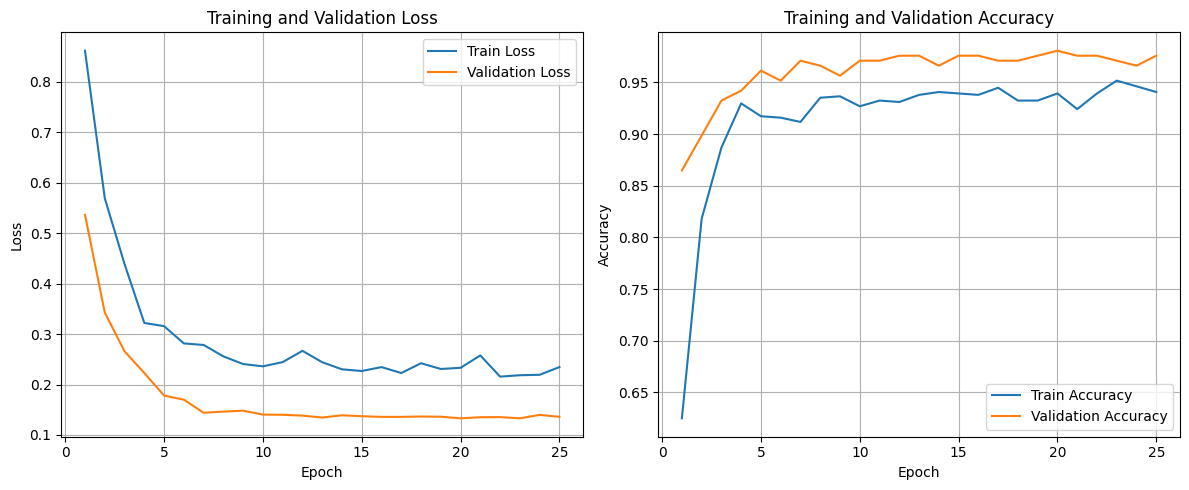

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_losses, train_accuracies, val_losses, val_accuracies lists are available from previous steps
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [12]:
from google.colab import files

# Descargar el modelo guardado
files.download('best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>